In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [4]:
def factor(df, window_size = 960, base_threshold=0.2, volatility_window=96):
    """
    ÊîπËøõÁÇπÔºö
    1. Ê†πÊçÆÂ∏ÇÂú∫Ê≥¢Âä®ÁéáÂä®ÊÄÅË∞ÉÊï¥Êàê‰∫§ÈáèÈòàÂÄº
    2. È´òÊ≥¢Âä®Â∏ÇÂú∫‰ΩøÁî®Êõ¥‰∏•Ê†ºÁöÑÈòàÂÄºÔºàÈÄâÂèñÊõ¥Â∞ëÂàÜÈíü‰Ωú‰∏∫ËÅ™ÊòéÈí±Ôºâ
    3. ÂºïÂÖ•Ëá™ÈÄÇÂ∫îÊú∫Âà∂Â∫îÂØπÊûÅÁ´ØË°åÊÉÖ
    """
    # ËÆ°ÁÆóÂ∏ÇÂú∫Ê≥¢Âä®ÁéáÔºàËøáÂéª24Â∞èÊó∂ATRÔºâ
    high, low, close = df['high'].values, df['low'].values, df['close'].values
    atr = np.zeros(len(df))
    for i in range(1, len(df)):
        tr = max(high[i] - low[i], 
                 abs(high[i] - close[i-1]), 
                 abs(low[i] - close[i-1]))
        atr[i] = (atr[i-1] * (volatility_window-1) + tr) / volatility_window
    
    # Ê≥¢Âä®ÁéáÂΩí‰∏ÄÂåñ (0-1ËåÉÂõ¥)
    norm_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-7)
    
    # Âä®ÊÄÅÈòàÂÄºÔºöÈ´òÊ≥¢Âä®Êó∂Èôç‰ΩéÈòàÂÄº
    dynamic_threshold = base_threshold * (1 - norm_atr * 0.5)  # Ê≥¢Âä®ÁéáÊúÄÂ§ßÊó∂ÈòàÂÄºÂáèÂçä
    
    # ÂÖ∂‰ΩôÈÉ®ÂàÜ‰øùÊåÅÂéüÂßãÂõ†Â≠êËÆ°ÁÆóÈÄªËæë
    # ... [Ê≠§Â§ÑÁúÅÁï•‰∏éÂéüÂßãÂõ†Â≠êÁõ∏ÂêåÁöÑËÆ°ÁÆóÈÉ®ÂàÜ] ...
    # È¢ÑËÆ°ÁÆóÊâÄÊúâÂøÖË¶ÅÂÄº
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    avg_price_vals = avg_price.values
    
    abs_ret = abs((df['close'] - df['open']) / df['open'])
    
    volume = df['volume'].values
        
    # ÂàùÂßãÂåñÂõ†Â≠êÂÄºÊï∞ÁªÑ
    factor_values = np.full(len(df), np.nan)
    
    # È¢ÑËÆ°ÁÆóSÂÄº (|R|/sqrt(V))
    S_values = abs_ret.values / np.sqrt(volume)
    
    # ‰ΩøÁî®ÊªëÂä®Á™óÂè£ËÆ°ÁÆó
    for i in range(window_size, len(df)):
        # Ëé∑ÂèñÂΩìÂâçÁ™óÂè£ÂàáÁâáÁ¥¢Âºï
        start_idx = i - window_size
        end_idx = i - 1
        
        # ÊèêÂèñÂΩìÂâçÁ™óÂè£Êï∞ÊçÆ
        window_avg_price = avg_price_vals[start_idx:end_idx]
        window_volume = volume[start_idx:end_idx]
        window_S = S_values[start_idx:end_idx]
        
        # ÊåâSÂÄºÈôçÂ∫èÊéíÂ∫èÁöÑÁ¥¢Âºï
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # ËÆ°ÁÆóÁ¥ØÁßØÊàê‰∫§Èáè
        cum_volume = np.cumsum(sorted_volume)
        total_volume = cum_volume[-1]
        
        # Âú®ËÆ°ÁÆó‰∏≠‰ΩøÁî®dynamic_threshold[i]Êõø‰ª£Âõ∫ÂÆöÈòàÂÄº
        threshold = total_volume * dynamic_threshold[i]
        
        
        smart_mask = cum_volume <= threshold
        if np.any(smart_mask):
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                               sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
        else:
            smart_vwap = np.nan
        
        # ËÆ°ÁÆóÊï¥‰ΩìVWAP
        all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
        
        # ËÆ°ÁÆóÂõ†Â≠êÂÄº
        if not np.isnan(smart_vwap) and all_vwap != 0:
            factor_values[i] = smart_vwap / all_vwap
            
    return pd.Series(factor_values, index=df.index)

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.011585
   Rank_IC (Spearman): 0.016998
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: 0.308638
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 130075
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


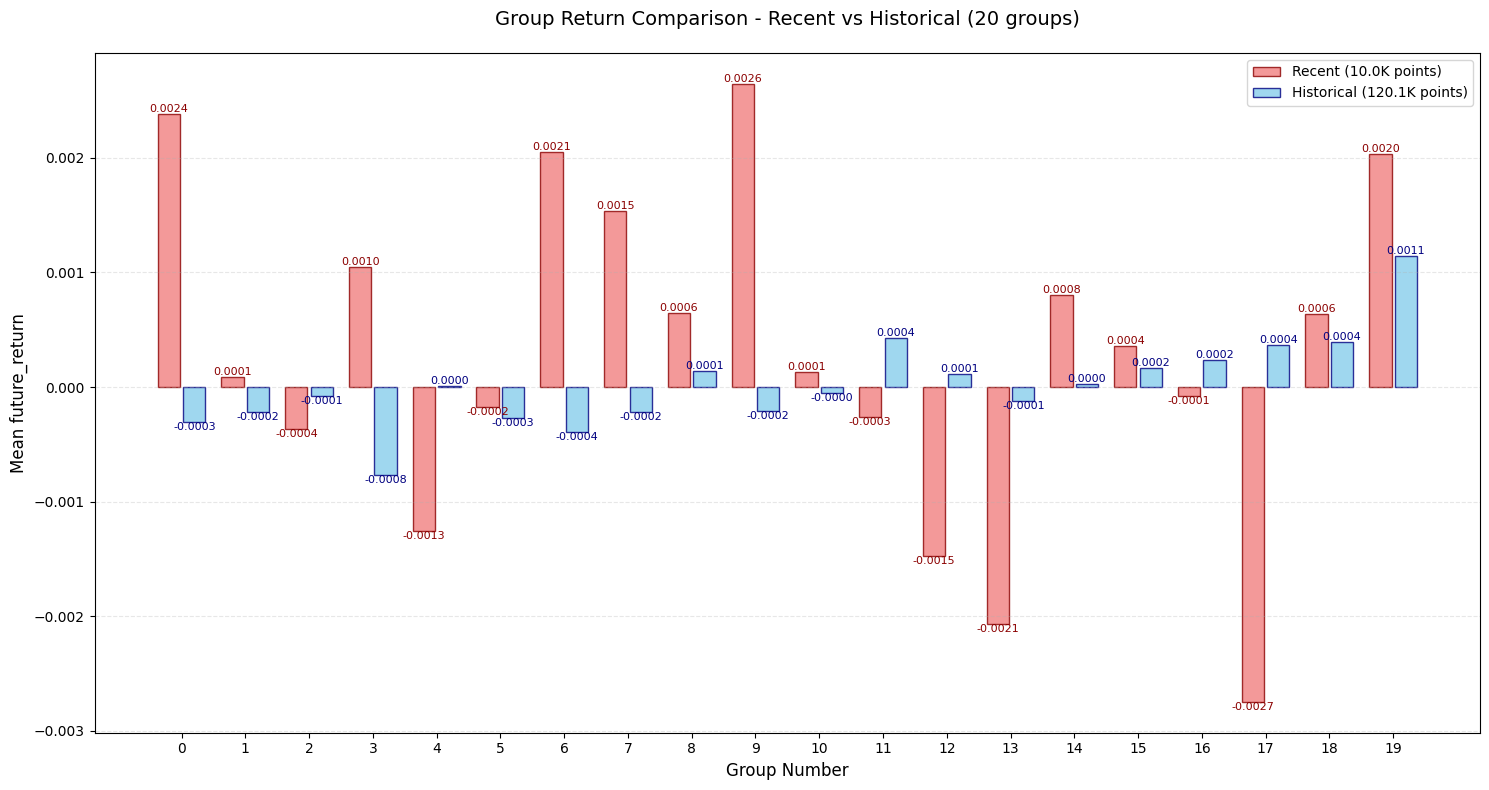

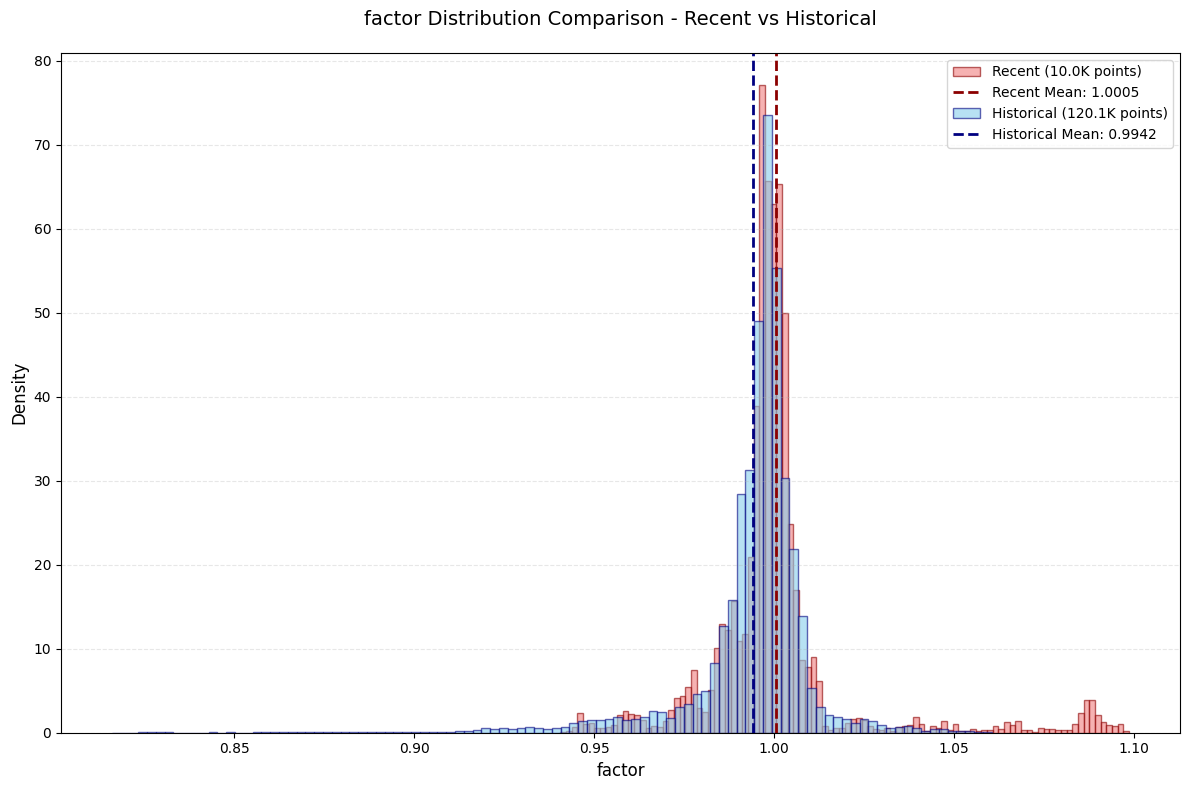

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

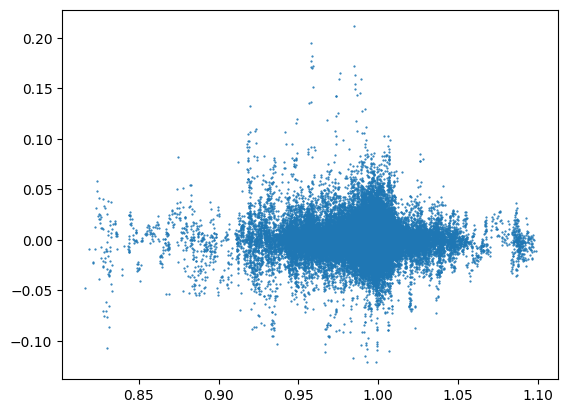

In [6]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [7]:
result['information_ratio']['group_correlations']
# ËøôË°®Á§∫‰∏çÂêåÂàÜÁªÑ‰πãÈó¥ÁöÑÁõ∏ÂÖ≥ÊÄßÔºåÈÄöÂ∏∏Áî®‰∫éËØÑ‰º∞Âõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãÁöÑË°®Áé∞‰∏ÄËá¥ÊÄß„ÄÇ
# Â¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉÈ´òÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞‰∏ÄËá¥ÔºõÂ¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉ‰ΩéÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞Â∑ÆÂºÇËæÉÂ§ß„ÄÇ

[-0.02899250291193383,
 0.004817499148662836,
 -0.0049578681989748,
 0.008137858301751141,
 -0.020749290976559278,
 0.04496137444110837,
 0.002873472158850747,
 0.028847798382216648,
 -0.004202092830986961,
 0.041347334910710305]

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.011584681331798033, 'Rank_IC': 0.01699774571022494}, 'information_ratio': {'IR': 0.3086378234257829, 'group_correlations': [-0.02899250291193383, 0.004817499148662836, -0.0049578681989748, 0.008137858301751141, -0.020749290976559278, 0.04496137444110837, 0.002873472158850747, 0.028847798382216648, -0.004202092830986961, 0.041347334910710305], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.8159   0.9638    0.9406      -0.0003      0.0210   6504
1       0.9638   0.9806    0.9735       0.0000      0.0156   6504
2       0.9806   0.9863    0.9840      -0.0001      0.0130   6504
3       0.9863   0.9896    0.9882      -0.0007      0.0117   6503
4       0.9896   0.9915    0.9907      -0.0000      0.0113   6504
5       0.9915   0.9932    0.9924      -0.0002      0.0112   6504
6       0.9932   0.9947    0.9940      -0.